In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [28]:
all_gb_df = pd.read_csv('../../data/derived/plays/all_gb_df.csv').drop(columns=['Unnamed: 0']) # rename togb_df
inf_gb_df = pd.read_csv('../../data/derived/plays/inf_gb_with_throw_1b_df.csv').drop('Unnamed: 0', axis=1)
player_pos_df = pd.read_csv('../../data/combined/player_pos.csv').drop(columns=['Unnamed: 0'])
game_info_df = pd.read_csv('../../data/combined/game_info.csv').drop(columns=['Unnamed: 0'])

Index(['game_str', 'home_team', 'away_team', 'at_bat', 'play_per_game',
       'inning', 'top_bottom_inning', 'pitcher', 'catcher', 'first_base',
       'second_base', 'third_base', 'shortstop', 'left_field', 'center_field',
       'right_field', 'batter', 'first_baserunner', 'second_baserunner',
       'third_baserunner'],
      dtype='object')

In [78]:
speed_df = all_gb_df.merge(inf_gb_df[['game_str', 'play_id', 'acquire_time', 'player_position']], on=['game_str', 'play_id'], how='inner', suffixes=('_contact', '_acquire'))
speed_df.drop(columns='player_position_contact', inplace=True)
speed_df.rename(columns={'timestamp': 'contact_time'}, inplace=True)

pos_dict = {4.0:'second_base', 5.0:'third_base', 6.0:'shortstop'}
cols = speed_df.columns.tolist()

speed_df = speed_df.merge(game_info_df, on=['game_str', 'play_per_game'], how='inner', suffixes=('', '_game'))
speed_df['player_id'] = speed_df.apply(lambda row: row[pos_dict[row['player_position_acquire']]], axis=1)
# Keep original columns and 'player_id'
speed_df = speed_df[cols + ['player_id']]
speed_df.drop(columns=['at_bat'], inplace=True)
speed_df.head()

,game_event_index,game_str,play_id,play_per_game,contact_time,event_code,acquire_time,player_position_acquire,player_id
0,60,1903_01_TeamNE_TeamA2,18,18,458331,4,460212,6,6000
1,145,1903_01_TeamNE_TeamA2,38,38,1091370,4,1092459,5,9762
2,211,1903_01_TeamNE_TeamA2,58,58,1615048,4,1616896,6,1972
3,438,1903_01_TeamNE_TeamA2,117,117,3636234,4,3638082,6,6000
4,449,1903_01_TeamNE_TeamA2,119,119,3792060,4,3794238,6,1972


In [71]:
### TRY NOT TO RUN THIS CELL

def calculate_max_speed_total_distance_per_play(play_row):
    player_pos_play = player_pos_df[
        (player_pos_df['game_str'] == play_row['game_str']) &
        (player_pos_df['timestamp'] >= play_row['contact_time']) &
        (player_pos_df['timestamp'] <= play_row['acquire_time']) &
        (player_pos_df['player_position'] == play_row['player_position_acquire'])
    ]
    
    if player_pos_play.empty:
        return None
    
    player_pos_play.sort_values(by='timestamp', inplace=True)
    
    positions = player_pos_play[['field_x', 'field_y']].values
    times = player_pos_play['timestamp'].values
    
    distances = np.sqrt(np.sum(np.diff(positions[::5], axis=0)**2, axis=1))
    speeds = distances / np.diff(times[::5])

    max_speed = np.max(speeds)
    total_distance = np.sum(distances)
    contact_to_field_time = play_row['acquire_time'] - play_row['contact_time']
    
    return play_row['player_id'], play_row['player_position_acquire'], max_speed, total_distance, contact_to_field_time
    
play_max_speed_total_distance = speed_df.apply(calculate_max_speed_total_distance_per_play, axis=1, result_type='expand')
play_max_speed_total_distance.columns = ['player_id', 'player_position_acquire', 'max_speed', 'total_distance', 'contact_to_field_time']

play_max_speed_total_distance.head()

,player_id,player_position_acquire,max_speed,total_distance,contact_to_field_time
0,6000.0,6.0,0.001150,1.320673,1881.0
1,9762.0,5.0,0.001412,0.919530,1089.0
2,1972.0,6.0,0.000318,0.226476,1848.0
3,6000.0,6.0,0.000955,1.038770,1848.0
4,1972.0,6.0,0.002634,2.677238,2178.0


In [79]:
speed_df['player_position_acquire'] = speed_df['player_position_acquire'].map(pos_dict)
speed_df.head()

,game_event_index,game_str,play_id,play_per_game,contact_time,event_code,acquire_time,player_position_acquire,player_id
0,60,1903_01_TeamNE_TeamA2,18,18,458331,4,460212,shortstop,6000
1,145,1903_01_TeamNE_TeamA2,38,38,1091370,4,1092459,third_base,9762
2,211,1903_01_TeamNE_TeamA2,58,58,1615048,4,1616896,shortstop,1972
3,438,1903_01_TeamNE_TeamA2,117,117,3636234,4,3638082,shortstop,6000
4,449,1903_01_TeamNE_TeamA2,119,119,3792060,4,3794238,shortstop,1972


In [82]:
# Handle 1.5 IQR outliers on total_distance and contact_to_field_time
q1 = play_max_speed_total_distance['total_distance'].quantile(0.25)
q3 = play_max_speed_total_distance['total_distance'].quantile(0.75)
iqr = q3 - q1

q1_time = play_max_speed_total_distance['contact_to_field_time'].quantile(0.25)
q3_time = play_max_speed_total_distance['contact_to_field_time'].quantile(0.75)
iqr_time = q3_time - q1_time

play_max_speed_total_distance = play_max_speed_total_distance.loc[play_max_speed_total_distance['total_distance'] < (q3 + 1.5 * iqr)]
play_max_speed_total_distance.head()

,player_id,player_position_acquire,max_speed,total_distance,contact_to_field_time
0,6000.0,6.0,0.001150,1.320673,1881.0
1,9762.0,5.0,0.001412,0.919530,1089.0
2,1972.0,6.0,0.000318,0.226476,1848.0
3,6000.0,6.0,0.000955,1.038770,1848.0
4,1972.0,6.0,0.002634,2.677238,2178.0


                 count       mean       std        min        25%        50%  \
player_position                                                                
second_base      220.0  23.986529  1.489812  22.544579  22.792362  23.258925   
shortstop         85.0  24.514779  1.605120  23.068008  23.516774  23.716913   
third_base        99.0  24.260205  1.745279  22.656783  23.068008  23.258925   

                       75%        max  
player_position                        
second_base      24.650178  27.115025  
shortstop        27.115025  27.115025  
third_base       26.401426  27.115025  


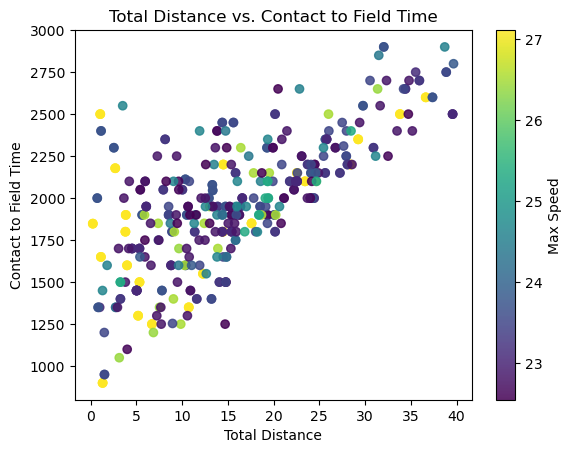

In [102]:
# If there is a csv file, read from it
# play_max_speed_total_distance = pd.read_csv('../../data/derived/fielderspeed/play_max_speed_total_distance.csv').drop(columns=['Unnamed: 0'])

player_max_speed = speed_df.merge(play_max_speed_total_distance, on=['player_id'], how='inner', suffixes=('', '_player'))
player_max_speed = player_max_speed.groupby(['player_id', 'player_position_acquire'])['max_speed'].max().reset_index()
player_max_speed = player_max_speed[['player_id', 'max_speed', 'player_position_acquire']]
player_max_speed.rename(columns={'player_position_acquire': 'player_position'}, inplace=True)
# Convert max_speed from ft/ms to ft/s
player_max_speed['max_speed'] = player_max_speed['max_speed'] * 1000

# Filter minimums
min_pos_speed = {
    'second_base': 22.5,
    'shortstop': 23,
    'third_base': 22.5,
}

player_max_speed = player_max_speed[player_max_speed.apply(lambda row: row['max_speed'] > min_pos_speed[row['player_position']], axis=1)]

player_max_speed_total_distance_on_play = play_max_speed_total_distance.merge(player_max_speed, on=['player_id'], how='inner', suffixes=('_play', '_player'))
player_max_speed_total_distance_on_play.rename(columns={'max_speed_player': 'max_speed'}, inplace=True)

print(player_max_speed_total_distance_on_play.groupby('player_position')['max_speed'].describe())

X = player_max_speed_total_distance_on_play[['total_distance', 'max_speed']]
y = player_max_speed_total_distance_on_play['contact_to_field_time']

plt.scatter(player_max_speed_total_distance_on_play['total_distance'], player_max_speed_total_distance_on_play['contact_to_field_time'], c=player_max_speed_total_distance_on_play['max_speed'], alpha=0.85)
plt.xlabel('Total Distance')
plt.ylabel('Contact to Field Time')
plt.title('Total Distance vs. Contact to Field Time')
plt.colorbar(label='Max Speed')
plt.show()

In [97]:
player_max_speed_total_distance_on_play.head()

,player_id,player_position_acquire,max_speed_play,total_distance,contact_to_field_time,max_speed,player_position
0,1972.0,6.0,0.000318,0.226476,1848.0,27.115025,second_base
1,1972.0,6.0,0.000318,0.226476,1848.0,27.115025,shortstop
2,1972.0,6.0,0.000318,0.226476,1848.0,27.115025,third_base
3,1972.0,6.0,0.002634,2.677238,2178.0,27.115025,second_base
4,1972.0,6.0,0.002634,2.677238,2178.0,27.115025,shortstop


In [99]:
player_max_speed.sort_values(by='max_speed', ascending=False, inplace=True)
player_max_speed.head()

,player_id,max_speed,player_position
31,1972,27.115025,second_base
32,1972,27.115025,shortstop
33,1972,27.115025,third_base
34,2053,26.523425,second_base
1,1119,26.401426,third_base
